In [47]:
import tensorflow as tf
from tensorflow import keras
import ipywidgets

In [2]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  0
2.9.1


2022-12-30 14:57:43.810186: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-30 14:57:43.810253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gradinstance1): /proc/driver/nvidia/version does not exist


'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [3]:
# ! pip install opencv-python

## Imports

In [4]:
import os
import io
import matplotlib.pyplot as plt
import cv2
import imageio
#import medmnist
#import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2 as cv

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
np.random.seed(SEED)

## Hyperparameters

The hyperparameters are chosen via hyperparameter
search. You can learn more about the process in the "conclusion" section.

In [5]:
# DATA
DATASET_NAME = "UCF-Crime-mini"
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (15, 100, 100, 1)
NUM_CLASSES = 13
TRAIN_RATIO = 0.7
TEST_RATIO = 0.25
VALIDATION_RATIO = 0.05

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [6]:
ROOT_PATH = "../datasets/ucf-crime-mini/dataset"

Abuse_PATH = ROOT_PATH + '/Abuse'
Arrest_PATH = ROOT_PATH + '/Arrest'
Assault_PATH = ROOT_PATH + '/Assault'
Burglary_PATH = ROOT_PATH + '/Burglary'
Fighting_PATH = ROOT_PATH + '/Fighting'
Normal_PATH = ROOT_PATH + '/normal'



OUT_PATH = "../out/vivit-ucf-mini/"

In [7]:
def extract_frames(directory, dimensions=(INPUT_SHAPE[1], INPUT_SHAPE[2]), packet_length = INPUT_SHAPE[0], save_dir_path = None):
    data = []

    for video_name in os.listdir(directory):
        video = cv2.VideoCapture(directory + '/' + video_name)
        packet = []
        while video.isOpened():
            ret, frame = video.read()

            if not ret: # no more frames
                break

            del ret

            # capturing the frame

            frame = cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            packet.append(frame)
            del frame

            if len(packet) == packet_length: 
                '''
                consecutive packets share 14 of the 15 frames to generate more data
                '''
                # packet itself is not normalized
                stacked = np.array(packet) # convert to numpy and normalize packet
                data.append(stacked.copy()) # this .copy() is not in the original code 
                del packet
                packet = []


        video.release()
        cv2.destroyAllWindows()

    del packet
    # TODO: read the docs for the next 2 lines
    data = np.stack(data, axis= 0)
#     data = np.moveaxis(data, 1 ,-1)

    # save to disk
    if(save_dir_path is not None):
        np.save(f'{save_dir_path}/data', data)

    return data

In [8]:
normal_frames = extract_frames(Normal_PATH)
print(normal_frames.shape)


(1282, 15, 100, 100)


In [9]:
abuse_frames    = extract_frames(Abuse_PATH)

In [10]:
arrest_frames   = extract_frames(Arrest_PATH)

In [11]:
assault_frames  = extract_frames(Assault_PATH)
burglary_frames = extract_frames(Burglary_PATH)
fighting_frames = extract_frames(Fighting_PATH)

(-0.5, 99.5, 99.5, -0.5)

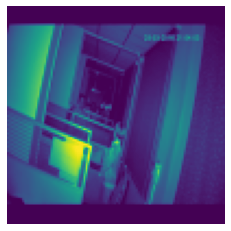

In [12]:
plt.imshow(normal_frames[0][1])
plt.axis('off')

## Extracting frames for 14 class

In [13]:
'''
Abuse_frames = np.load(r"G:\UCF-crime\Abuse_frames.npy")
Arrest_frames = np.load(r"G:\UCF-crime\Arrest_frames.npy")
Assault_frames = np.load(r"G:\UCF-crime\Assault_frames.npy")
Burglary_frames = np.load(r"G:\UCF-crime\Burglary_frames.npy")
Explosion_frames = np.load(r"G:\UCF-crime\Explosion_frames.npy")
Fighting_frames = np.load(r"G:\UCF-crime\Fighting_frames.npy")
RoadAccidents_frames = np.load(r"G:\UCF-crime\RoadAccidents_frames.npy")
Robbery_frames = np.load(r"G:\UCF-crime\Robbery_frames.npy")
Shooting_frames = np.load(r"G:\UCF-crime\Shooting_frames.npy")
Shoplifting_frames = np.load(r"G:\UCF-crime\Shoplifting_frames.npy")
Stealing_frames = np.load(r"G:\UCF-crime\Stealing_frames.npy")
Vandalism_frames = np.load(r"G:\UCF-crime\Vandalism_frames.npy")
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 28-31: truncated \UXXXXXXXX escape (3298918565.py, line 1)

In [ ]:
# Abuse_frames = extract_frames(Abuse_PATH)
# print(Abuse_frames.shape)
# np.save(r"G:\UCF-crime\Abuse_frames", Abuse_frames)

In [14]:
print(abuse_frames.shape)

(1374, 15, 100, 100)


In [15]:
abuse_labels = np.full((abuse_frames.shape[0]), 0)

In [ ]:
# Arrest_frames = extract_frames(Arrest_PATH)
# print(Arrest_frames.shape)
# np.save(r"G:\UCF-crime\Arrest_frames", Arrest_frames)

In [16]:
arrest_labels = np.full((arrest_frames.shape[0]), 1)

In [ ]:
# Assault_frames = extract_frames(Assault_PATH)
# print(Assault_frames.shape)
# np.save(r"G:\UCF-crime\Assault_frames", Assault_frames)

In [17]:
assault_labels = np.full((assault_frames.shape[0]), 2)

In [ ]:
#Burglary_frames = extract_frames(Burglary_PATH)
#print(Burglary_frames.shape)
#np.save(r"G:\UCF-crime\Burglary_frames", Burglary_frames)

In [18]:
burglary_labels = np.full((burglary_frames.shape[0]), 3)

In [ ]:
#Fighting_frames = extract_frames(Fighting_PATH)
#print(Fighting_frames.shape)
#np.save(r"G:\UCF-crime\Fighting_frames", Fighting_frames)

In [19]:
fighting_labels = np.full((fighting_frames.shape[0]), 4)

In [20]:
normal_labels = np.full((normal_frames.shape[0]), 5)

# Loading frames

# Data split

In [ ]:
# x = normal_frames.copy()
# del normal_frames

In [ ]:
# x = np.concatenate((x,fighting_frames))
# del fighting_frames

: 

: 

In [21]:
x = np.concatenate((normal_frames,abuse_frames, arrest_frames, assault_frames, burglary_frames, fighting_frames))
print(x.shape)

(9553, 15, 100, 100)


In [22]:
y = np.concatenate((normal_labels,abuse_labels, arrest_labels, assault_labels, burglary_labels, fighting_labels))
print(np.unique(y))

[0 1 2 3 4 5]


In [23]:
import gc
for i in range(100):
    gc.collect()

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 x, y, test_size=0.3, random_state=42, stratify = y)

X_test, X_validate, y_test, y_validate = train_test_split(
 X_test, y_test, test_size=0.2, random_state=42, stratify = y_test)

In [25]:
print( X_train.shape, X_test.shape, X_validate.shape, y_train.shape, y_test.shape, y_validate.shape)

(6687, 15, 100, 100) (2292, 15, 100, 100) (574, 15, 100, 100) (6687,) (2292,) (574,)


0 (6687, 15, 100, 100)


(-0.5, 99.5, 99.5, -0.5)

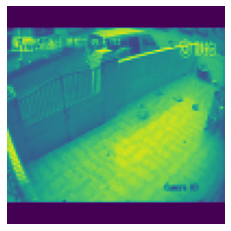

In [26]:
print(y_train[3], X_train.shape)
plt.imshow(X_train[3][0])
plt.axis('off')

### `tf.data` pipeline

In [27]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [28]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels,
                 to_fit=True, batch_size=128, dim=(15, 100, 100),
                 n_channels=1, n_classes=13, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_grayscale_image(self.image_path + self.labels[ID])

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_grayscale_image(self.mask_path + self.labels[ID])

        return y
training_generator = DataGenerator(X_train, y_train)
validation_generator = DataGenerator(X_validate, y_validate)

In [29]:
len(training_generator)

52

In [31]:
X_validate.shape, y_train.shape

((574, 15, 100, 100), (6687,))

In [32]:

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


In [33]:

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


In [34]:

def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [36]:
model_checkpoint = ModelCheckpoint("../checkpoints/vivit-mini-ucf",
                monitor='val_loss',
                save_best_only=True)

## Train

In [38]:

def run_experiment():
    mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/cpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    with mirrored_strategy.scope():
    # Initialize model
        model = create_vivit_classifier(
            tubelet_embedder=TubeletEmbedding(
                embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
            ),
            positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
        )

        # Compile the model with the optimizer, loss function
        # and the metrics.
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )

        # Train the model.
        history = model.fit(X_train,y_train, epochs=EPOCHS, validation_data=(X_validate,y_validate), callbacks=[model_checkpoint])

        # _, accuracy, top_5_accuracy = model.evaluate(testloader)
        # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
        # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history


model, history = run_experiment()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/60


2022-12-30 15:07:05.124449: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_7398"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:26"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUC

209/209 [==============================] - ETA: 0s - loss: 1.4186 - accuracy: 0.4483 - top-5-accuracy: 0.9595

2022-12-30 15:10:26.833388: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_19676"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:54"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 222s 1s/step - loss: 1.4186 - accuracy: 0.4483 - top-5-accuracy: 0.9595 - val_loss: 1.2518 - val_accuracy: 0.5139 - val_top-5-accuracy: 0.9826
Epoch 2/60
209/209 [==============================] - ETA: 0s - loss: 1.2416 - accuracy: 0.5188 - top-5-accuracy: 0.9713

2022-12-30 15:13:59.200602: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 210s 1s/step - loss: 1.2416 - accuracy: 0.5188 - top-5-accuracy: 0.9713 - val_loss: 1.1179 - val_accuracy: 0.5801 - val_top-5-accuracy: 0.9774
Epoch 3/60
209/209 [==============================] - ETA: 0s - loss: 1.1501 - accuracy: 0.5638 - top-5-accuracy: 0.9770

2022-12-30 15:17:27.824616: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 209s 999ms/step - loss: 1.1501 - accuracy: 0.5638 - top-5-accuracy: 0.9770 - val_loss: 1.0583 - val_accuracy: 0.6341 - val_top-5-accuracy: 0.9756
Epoch 4/60
209/209 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.6226 - top-5-accuracy: 0.9834

2022-12-30 15:20:54.896076: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 207s 990ms/step - loss: 1.0411 - accuracy: 0.6226 - top-5-accuracy: 0.9834 - val_loss: 0.9122 - val_accuracy: 0.6289 - val_top-5-accuracy: 0.9878
Epoch 5/60
209/209 [==============================] - ETA: 0s - loss: 0.8877 - accuracy: 0.6818 - top-5-accuracy: 0.9873

2022-12-30 15:24:22.095532: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 208s 993ms/step - loss: 0.8877 - accuracy: 0.6818 - top-5-accuracy: 0.9873 - val_loss: 0.7168 - val_accuracy: 0.7352 - val_top-5-accuracy: 0.9878
Epoch 6/60
209/209 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.7844 - top-5-accuracy: 0.9891

2022-12-30 15:27:50.125812: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 208s 995ms/step - loss: 0.6726 - accuracy: 0.7844 - top-5-accuracy: 0.9891 - val_loss: 0.4749 - val_accuracy: 0.8815 - val_top-5-accuracy: 0.9930
Epoch 7/60
209/209 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.8469 - top-5-accuracy: 0.9913

2022-12-30 15:31:16.928100: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 207s 991ms/step - loss: 0.5149 - accuracy: 0.8469 - top-5-accuracy: 0.9913 - val_loss: 0.3854 - val_accuracy: 0.8937 - val_top-5-accuracy: 1.0000
Epoch 8/60
209/209 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.9000 - top-5-accuracy: 0.9967

2022-12-30 15:34:42.177419: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 205s 981ms/step - loss: 0.3697 - accuracy: 0.9000 - top-5-accuracy: 0.9967 - val_loss: 0.3021 - val_accuracy: 0.9164 - val_top-5-accuracy: 1.0000
Epoch 9/60
209/209 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9351 - top-5-accuracy: 0.9982

2022-12-30 15:38:07.977216: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 206s 985ms/step - loss: 0.2392 - accuracy: 0.9351 - top-5-accuracy: 0.9982 - val_loss: 0.1967 - val_accuracy: 0.9286 - val_top-5-accuracy: 0.9983
Epoch 10/60
209/209 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9511 - top-5-accuracy: 0.9996

2022-12-30 15:41:33.009151: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 205s 980ms/step - loss: 0.1721 - accuracy: 0.9511 - top-5-accuracy: 0.9996 - val_loss: 0.1390 - val_accuracy: 0.9686 - val_top-5-accuracy: 0.9965
Epoch 11/60
209/209 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9711 - top-5-accuracy: 0.9991

2022-12-30 15:44:56.594950: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 204s 975ms/step - loss: 0.1174 - accuracy: 0.9711 - top-5-accuracy: 0.9991 - val_loss: 0.0646 - val_accuracy: 0.9826 - val_top-5-accuracy: 1.0000
Epoch 12/60
209/209 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9804 - top-5-accuracy: 0.9996

2022-12-30 15:48:20.540397: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 204s 977ms/step - loss: 0.0792 - accuracy: 0.9804 - top-5-accuracy: 0.9996 - val_loss: 0.0502 - val_accuracy: 0.9878 - val_top-5-accuracy: 1.0000
Epoch 13/60
209/209 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9858 - top-5-accuracy: 0.9999

2022-12-30 15:51:44.232095: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 914ms/step - loss: 0.0506 - accuracy: 0.9858 - top-5-accuracy: 0.9999 - val_loss: 0.0572 - val_accuracy: 0.9895 - val_top-5-accuracy: 1.0000
Epoch 14/60
209/209 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9901 - top-5-accuracy: 0.9997

2022-12-30 15:54:55.251898: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 203s 973ms/step - loss: 0.0425 - accuracy: 0.9901 - top-5-accuracy: 0.9997 - val_loss: 0.0287 - val_accuracy: 0.9878 - val_top-5-accuracy: 1.0000
Epoch 15/60
209/209 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9942 - top-5-accuracy: 1.0000

2022-12-30 15:58:18.552181: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 914ms/step - loss: 0.0243 - accuracy: 0.9942 - top-5-accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 0.9826 - val_top-5-accuracy: 1.0000
Epoch 16/60
209/209 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.9139 - top-5-accuracy: 0.9966

2022-12-30 16:01:29.053444: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 912ms/step - loss: 0.2767 - accuracy: 0.9139 - top-5-accuracy: 0.9966 - val_loss: 0.1155 - val_accuracy: 0.9617 - val_top-5-accuracy: 1.0000
Epoch 17/60
209/209 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9928 - top-5-accuracy: 0.9999

2022-12-30 16:04:39.754753: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 912ms/step - loss: 0.0349 - accuracy: 0.9928 - top-5-accuracy: 0.9999 - val_loss: 0.0370 - val_accuracy: 0.9861 - val_top-5-accuracy: 1.0000
Epoch 18/60
209/209 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9951 - top-5-accuracy: 0.9999

2022-12-30 16:07:50.722436: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 914ms/step - loss: 0.0224 - accuracy: 0.9951 - top-5-accuracy: 0.9999 - val_loss: 0.0326 - val_accuracy: 0.9913 - val_top-5-accuracy: 1.0000
Epoch 19/60
209/209 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9952 - top-5-accuracy: 0.9999

2022-12-30 16:11:03.647046: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 206s 985ms/step - loss: 0.0200 - accuracy: 0.9952 - top-5-accuracy: 0.9999 - val_loss: 0.0135 - val_accuracy: 0.9948 - val_top-5-accuracy: 1.0000
Epoch 20/60
209/209 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9922 - top-5-accuracy: 0.9999

2022-12-30 16:14:30.636785: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 194s 929ms/step - loss: 0.0284 - accuracy: 0.9922 - top-5-accuracy: 0.9999 - val_loss: 0.0257 - val_accuracy: 0.9895 - val_top-5-accuracy: 1.0000
Epoch 21/60
209/209 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9969 - top-5-accuracy: 1.0000

2022-12-30 16:17:44.511269: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 206s 986ms/step - loss: 0.0120 - accuracy: 0.9969 - top-5-accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.9965 - val_top-5-accuracy: 1.0000
Epoch 22/60
209/209 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9973 - top-5-accuracy: 1.0000

2022-12-30 16:21:07.505519: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 913ms/step - loss: 0.0109 - accuracy: 0.9973 - top-5-accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9930 - val_top-5-accuracy: 1.0000
Epoch 23/60
209/209 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9940 - top-5-accuracy: 1.0000

2022-12-30 16:24:18.743369: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 204s 975ms/step - loss: 0.0244 - accuracy: 0.9940 - top-5-accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9948 - val_top-5-accuracy: 1.0000
Epoch 24/60
209/209 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9945 - top-5-accuracy: 1.0000

2022-12-30 16:27:41.681518: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 912ms/step - loss: 0.0184 - accuracy: 0.9945 - top-5-accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9948 - val_top-5-accuracy: 1.0000
Epoch 25/60
209/209 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9933 - top-5-accuracy: 0.9997

2022-12-30 16:30:52.262250: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 191s 912ms/step - loss: 0.0256 - accuracy: 0.9933 - top-5-accuracy: 0.9997 - val_loss: 0.0753 - val_accuracy: 0.9878 - val_top-5-accuracy: 1.0000
Epoch 26/60
209/209 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9885 - top-5-accuracy: 0.9999

2022-12-30 16:34:02.626222: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


209/209 [==============================] - 190s 911ms/step - loss: 0.0423 - accuracy: 0.9885 - top-5-accuracy: 0.9999 - val_loss: 0.1123 - val_accuracy: 0.9652 - val_top-5-accuracy: 1.0000
Epoch 27/60
209/209 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9931 - top-5-accuracy: 0.9997

2022-12-30 16:37:13.261224: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 203s 971ms/step - loss: 0.0251 - accuracy: 0.9931 - top-5-accuracy: 0.9997 - val_loss: 0.0099 - val_accuracy: 0.9965 - val_top-5-accuracy: 1.0000
Epoch 28/60
209/209 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9988 - top-5-accuracy: 1.0000

2022-12-30 16:40:37.747964: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


INFO:tensorflow:Assets written to: ../checkpoints/vivit-mini-ucf/assets


209/209 [==============================] - 205s 983ms/step - loss: 0.0058 - accuracy: 0.9988 - top-5-accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 29/60
 95/209 [============>.................] - ETA: 1:44 - loss: 0.0054 - accuracy: 0.9980 - top-5-accuracy: 1.0000

KeyboardInterrupt: 

In [42]:
model = create_vivit_classifier(
    tubelet_embedder=TubeletEmbedding(
        embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
    ),
    positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
)

# Compile the model with the optimizer, loss function
# and the metrics.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

model.load_weights("../checkpoints/vivit-mini-ucf")

2022-12-30 16:53:49.388620: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../checkpoints/vivit-mini-ucf: FAILED_PRECONDITION: ../checkpoints/vivit-mini-ucf; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [43]:
num=len(history.history['loss'])

plt.plot(range(num),history.history['loss'],label = 'training loss')
plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

plt.legend()

plt.xlabel("Epochs ")
plt.ylabel('Loss')

plt.figure()

plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

plt.legend()
plt.xlabel("Epochs ")

NameError: name 'history' is not defined

## Inference

In [50]:
model.evaluate(X_test,y_test)


72/72 [==============================] - 22s 295ms/step - loss: 0.0215 - accuracy: 0.9969 - top-5-accuracy: 0.9996


[0.02153450809419155, 0.9969459176063538, 0.9995636940002441]

In [61]:
from sklearn.metrics import f1_score, classification_report

y_pred = np.argmax(model.predict(X_test),axis=-1)
f1_score(y_test, y_pred, average='micro')

target_names = [
    "normal",
    "abuse",
    "arrest",
    "assault",
    "burglary",
    "fighting",
]


print(classification_report(y_test, y_pred, target_names=target_names))

72/72 [==============================] - 22s 300ms/step
              precision    recall  f1-score   support

      normal       1.00      0.99      1.00       329
       abuse       1.00      0.99      0.99       635
      arrest       0.99      1.00      0.99       140
     assault       1.00      1.00      1.00       484
    burglary       0.99      1.00      1.00       397
    fighting       1.00      1.00      1.00       307

    accuracy                           1.00      2292
   macro avg       1.00      1.00      1.00      2292
weighted avg       1.00      1.00      1.00      2292



In [68]:
! pip install seaborn

In [70]:
np.save("../out/vivit-ucf-mini/y_train",y_train)
np.save("../out/vivit-ucf-mini/y_test",y_test)
np.save("../out/vivit-ucf-mini/y_validate",y_validate)
np.save("../out/vivit-ucf-mini/y_pred",y_pred)

np.save("../out/vivit-ucf-mini/X_train",X_train)
np.save("../out/vivit-ucf-mini/X_test",X_test)
np.save("../out/vivit-ucf-mini/X_validate",X_validate)


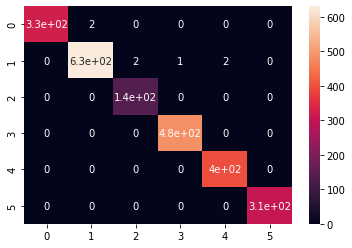

In [4]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix as cm

y_pred = np.load("../out/vivit-ucf-mini/y_pred.npy")
y_test = np.load("../out/vivit-ucf-mini/y_test.npy")
conf = cm(y_test,y_pred)

sns.heatmap(conf,annot=True)